# GP-ConvCNP Examples

This notebook will allow you to explore our proposed GP-ConvCNP as well as all the baselines. You will need to install the `neuralprocess` package contained within the ZIP file you received. For instructions on how to do that, please consult the `README.md`.

Below, we will first construct data generators that produce functions like the ones used in the paper. We then load pretrained models and visualize predictions similar to the figures found in our paper.

We will use the following abbreviations for the different function families:

* `matern` for samples from a Gaussian Process with a Matern-5/2 kernel
* `wp` for samples from a Gaussian Process with a weakly periodic kernel
* `step` for step function samples

## Imports

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import ipywidgets as widgets
from IPython.display import display
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

from neuralprocess.data import GaussianProcessGenerator, StepFunctionGenerator, gp
from neuralprocess.model import pretrained
from neuralprocess import util

## Data Generators

These generators are constructed to match what the models were trained on (except num_context and num_target, which are fixed). Feel free to change parameters to see how well the methods handle those changes, both in distribution (e.g. num_context from 5 to 50) and out of distribution (e.g. different kernel lengthscale)

In [45]:
base_kwargs = dict(
    batch_size=1,
    x_range=(-3, 3),
    num_context=20,
    num_target=200,
    output_noise=0.,
    linspace=True
)

generators = {
    "matern": GaussianProcessGenerator(
        **base_kwargs,
        kernel_type=gp.Matern52Kernel,
        kernel_kwargs=dict(lengthscale=0.5)
    ),
    "wp": GaussianProcessGenerator(
        **base_kwargs,
        kernel_type=gp.WeaklyPeriodicKernel,
        kernel_kwargs=dict()
    ),
    "step": StepFunctionGenerator(
        **base_kwargs,
        y_range=(-3, 3),
        number_of_steps=(3, 10),
        min_step_width=0.1,
        min_step_height=0.1
    )
}

## Pretrained Models

The models are very small (NP ~1.3MB, ANP ~2.1MB, ConvCNP & GP-ConvCNP ~207kB), so we can load them all at once.

In [46]:
NP_models = {}
ANP_models = {}
ConvCNP_models = {}
GPConvCNP_models = {}

for function_type in ("matern", "wp", "step"):
    NP_models[function_type] = pretrained.NeuralProcess(function_type).eval()
    ANP_models[function_type] = pretrained.AttentiveNeuralProcess(function_type).eval()
    ConvCNP_models[function_type] = pretrained.ConvCNP(function_type, use_gp=False).eval()
    GPConvCNP_models[function_type] = pretrained.ConvCNP(function_type, use_gp=True).eval()

## Random Examples

With the following cell you can generate random examples for the different function types, like the ones seen in the supplementary material of our submission (and similar to the ones in the main text). Each row consists of two sub-rows, the first of which shows the mean predictions by all methods, while the second shows samples. At the top of the cell are a number of configuration options:

* `function_type` selects which function generator and models are used.
* `num_samples` is the number of samples we draw from a method for a given example
* `num_rows` is the number of examples (the figure itself will have 2*num_rows rows)
* `x_range` defines the ran

/home/jens/anaconda3/lib/python3.6/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


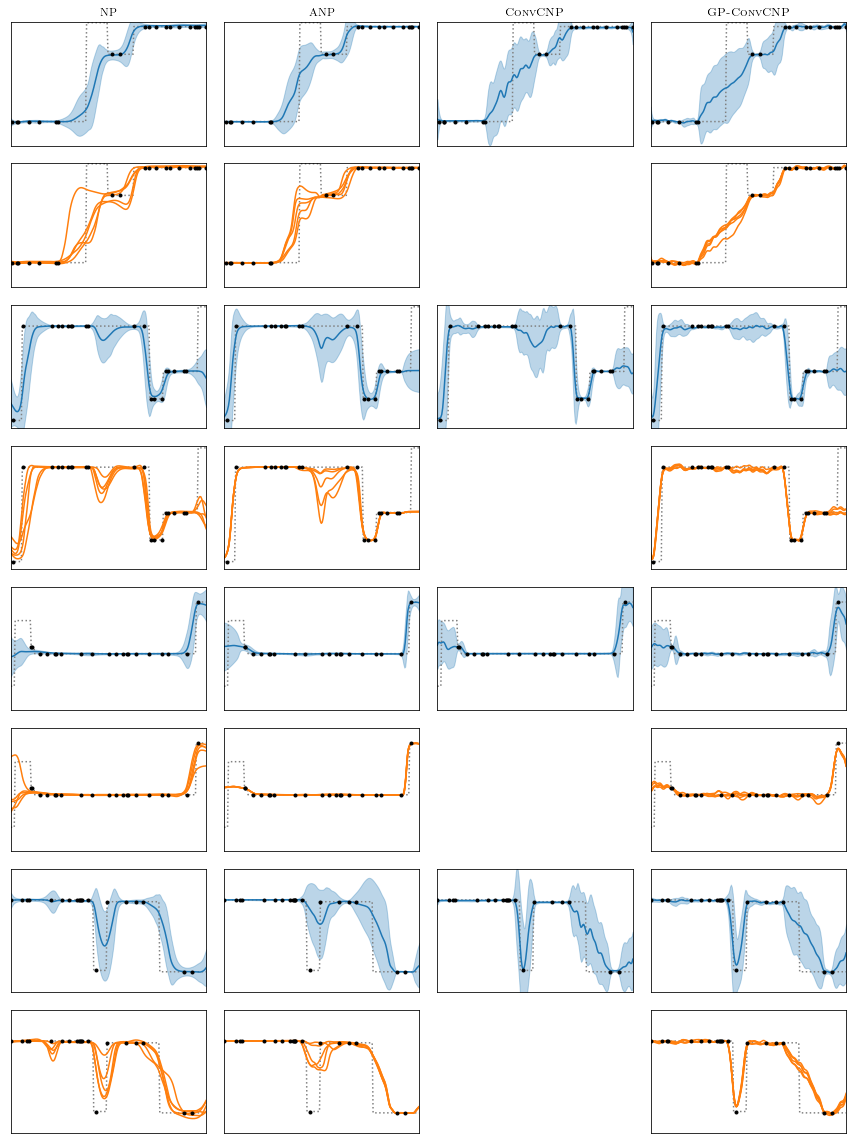

In [72]:
function_type = "step"  # you can change this to "wp" or "step"
num_samples = 5  # number of samples for each example
num_rows = 4  # each row is a different random draw
x_range = (-3, 3)  # make this wider than (3, 3) to see out-of-distribution behaviour
show_ticks = False  # You can use this to toggle axis ticks
prediction_color = cm.tab10(0)
sample_color = cm.tab10(1)

# change generator to specified x_range and store old value
old_x_range = generators[function_type].x_range
generators[function_type].x_range = x_range

%matplotlib inline
fig, ax = plt.subplots(2*num_rows, 4, figsize=(12, 4*num_rows))

for r in range(num_rows):
    
    batch = next(generators[function_type])
    
    func = function_type
    for m, model in enumerate((NP_models[func], ANP_models[func], ConvCNP_models[func], GPConvCNP_models[func])):
        with torch.no_grad():
            
            ax[2*r, m].set_xlim(*x_range)
            ax[2*r+1, m].set_xlim(*x_range)
            ax[2*r, m].set_ylim(-3, 3)
            ax[2*r+1, m].set_ylim(-3, 3)
            
            ax[2*r, m].plot(batch["target_in"][0, :, 0], batch["target_out"][0, :, 0],
                            c="grey", linestyle=":")
            if m != 2:
                ax[2*r+1, m].plot(batch["target_in"][0, :, 0], batch["target_out"][0, :, 0],
                                  c="grey", linestyle=":")
            
            prediction = model(batch["context_in"], batch["context_out"], batch["target_in"], store_rep=True)
            prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=-1)
            
            if x_range[0] < -3.:
                ax[2*r, m].axvline(-3, c="black", alpha=0.3)
                if m != 2:
                    ax[2*r+1, m].axvline(-3, c="black", alpha=0.3)
            if x_range[1] > 3.:
                ax[2*r, m].axvline(3, c="black", alpha=0.3)
                if m != 2:
                    ax[2*r+1, m].axvline(3, c="black", alpha=0.3)
                
            ax[2*r, m].plot(batch["target_in"][0, :, 0], prediction.loc[0, :, 0], c=prediction_color)
            ax[2*r, m].fill_between(batch["target_in"][0, :, 0],
                                 prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                                 prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                                 color=prediction_color,
                                 alpha=0.3)
            
            if m != 2:
                samples = model.sample(batch["target_in"], num_samples)
                ax[2*r+1, m].plot(batch["target_in"][0, :], samples[:, 0, :, 0].T, c=sample_color)
            else:
                ax[2*r+1, m].axis("off")
                
            ax[2*r, m].plot(batch["context_in"][0, :, 0], batch["context_out"][0, :, 0],
                            c="black", marker="o", ms=3, linewidth=0)
            if m != 2:
                ax[2*r+1, m].plot(batch["context_in"][0, :, 0], batch["context_out"][0, :, 0],
                                  c="black", marker="o", ms=3, linewidth=0)
                
            if not show_ticks:
                ax[2*r, m].set_xticks([])
                ax[2*r, m].set_yticks([])
                ax[2*r+1, m].set_xticks([])
                ax[2*r+1, m].set_yticks([])
            
ax[0, 0].set_title("NP")
ax[0, 1].set_title("ANP")
ax[0, 2].set_title(r"\textsc{ConvCNP}")
ax[0, 3].set_title(r"\textsc{GP-ConvCNP}")
        
fig.tight_layout()
plt.show()

## Sampling Examples

## Interactive Example

The following interactive example gives you the opportunity to manually place context points and see how the different methods behave. There are checkboxes to activate each method individually as well as one to toggle display of the predictive uncertainty. A dropdown menu gives you the option to select on what kinds of functions the models should have been trained. This example is especially useful to explore corner cases and failure modes. It's easy to place context points in a way that makes them unlikely to come from a true sample, and the predictions will reflect that. The training range will be indicated by vertical lines, keepin mind that NP and ANP perform very poorly when points are placed outside of that range.

The top panel shows mean predictions and the bottom panel shows samples. The panels will be empty in the beginning, and you need to manually add points. You can remove points by clicking on them again. Note that only the top panel is interactive!

Checkbox(value=True, description='GP-ConvCNP')

Checkbox(value=False, description='ConvCNP')

Checkbox(value=False, description='ANP')

Checkbox(value=False, description='NP')

Checkbox(value=True, description='Show Sigma')

Dropdown(description='Type', options=('matern', 'wp', 'step'), value='matern')

<IPython.core.display.Javascript object>


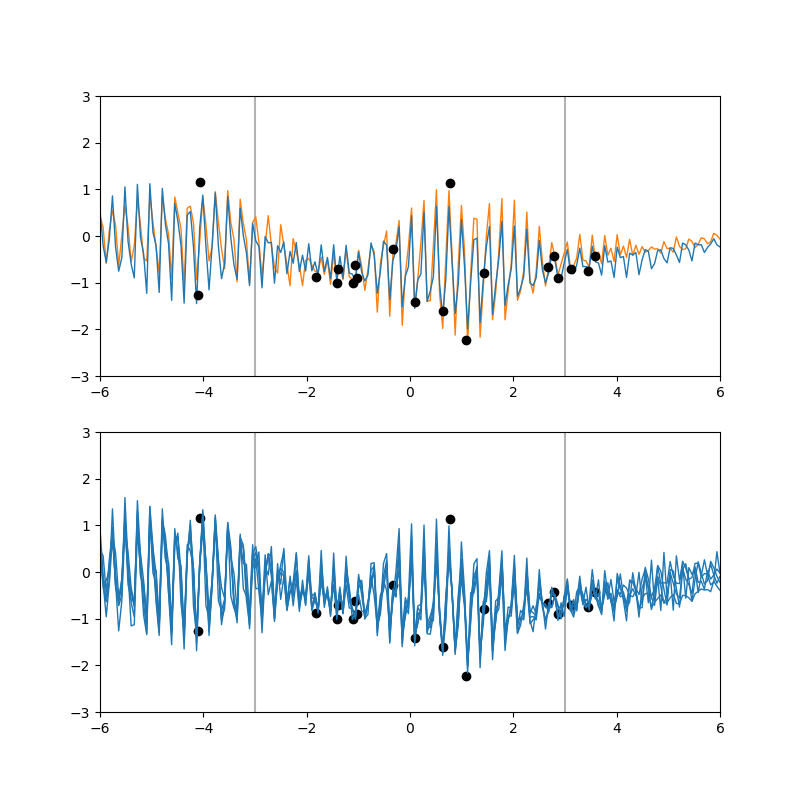

In [41]:
%matplotlib notebook

x_range = (-6, 6)
num_samples = 5

# Set up selectors
gpconvcnp_box = widgets.Checkbox(value=True, description="GP-ConvCNP")
convcnp_box = widgets.Checkbox(value=False, description="ConvCNP")
anp_box = widgets.Checkbox(value=False, description="ANP")
np_box = widgets.Checkbox(value=False, description="NP")
sigma_box = widgets.Checkbox(value=True, description="Show Sigma")
function_selector = widgets.Dropdown(
    options=["matern", "wp", "step"],
    value="matern",
    description="Type"
)
display(gpconvcnp_box, convcnp_box, anp_box, np_box, sigma_box, function_selector)

class FigureBuilder:
    
    def __init__(self, ax):
        
        self.ax = ax

        self.sigma_handle_np = ax[0].fill_between([], [], [], color=cm.tab10(3), alpha=0.3)
        self.prediction_handle_np = ax[0].plot([], [], color=cm.tab10(3), linewidth=1)[0]
        self.sigma_handle_anp = ax[0].fill_between([], [], [], color=cm.tab10(2), alpha=0.3)
        self.prediction_handle_anp = ax[0].plot([], [], color=cm.tab10(2), linewidth=1)[0]
        self.sigma_handle_convcnp = ax[0].fill_between([], [], [], color=cm.tab10(1), alpha=0.3)
        self.prediction_handle_convcnp = ax[0].plot([], [], color=cm.tab10(1), linewidth=1)[0]
        self.sigma_handle_gpconvcnp = ax[0].fill_between([], [], [], color=cm.tab10(0), alpha=0.3)
        self.prediction_handle_gpconvcnp = ax[0].plot([], [], color=cm.tab10(0), linewidth=1)[0]
        
        self.sample_handles_np = None
        self.sample_handles_anp = None
        self.sample_handles_gpconvcnp = None
        
        self.context_handle_0 = ax[0].plot([], [], color="black", linewidth=0, marker="o", ms=6)[0]
        self.context_handle_1 = ax[1].plot([], [], color="black", linewidth=0, marker="o", ms=6)[0]
        self.context_points = []
        self.cid = self.context_handle_0.figure.canvas.mpl_connect('button_press_event', self)
        
    def draw(self, *args, **kwargs):
        
        self.sigma_handle_np.get_paths().clear()
        self.sigma_handle_anp.get_paths().clear()
        self.sigma_handle_convcnp.get_paths().clear()
        self.sigma_handle_gpconvcnp.get_paths().clear()
        
        if len(self.context_points) > 0:
            
            # context points
            arr = np.array(self.context_points)
            self.context_handle_0.set_data(arr[:, 0], arr[:, 1])
            self.context_handle_1.set_data(arr[:, 0], arr[:, 1])
            
            # prediction
            context_in = torch.from_numpy(arr[:, 0]).float().reshape(1, -1, 1)
            context_out = torch.from_numpy(arr[:, 1]).float().reshape(1, -1, 1)
            target_in = torch.linspace(*x_range, 200).reshape(1, -1, 1)
            
            with torch.no_grad():
                
                func = function_selector.value
                
                if gpconvcnp_box.value:
                    prediction = GPConvCNP_models[func](context_in, context_out, target_in, store_rep=True)
                    prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)    
                    self.prediction_handle_gpconvcnp.set_data(target_in[0, :, 0], prediction.loc[0, :, 0])
                    if sigma_box.value:
                        self.sigma_handle_gpconvcnp = self.ax[0].fill_between(
                            target_in[0, :, 0],
                            prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                            prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                            color=cm.tab10(0),
                            alpha=0.3
                        )
                    samples = GPConvCNP_models[func].sample(target_in, num_samples)
                    samples = util.tensor_to_loc_scale(samples, torch.distributions.Normal, axis=-1)
                    if self.sample_handles_gpconvcnp is None:
                        self.sample_handles_gpconvcnp = self.ax[1].plot(target_in[0],
                                                                        samples.loc[:, 0, :, 0].T,
                                                                        color=cm.tab10(0),
                                                                        linewidth=1)
                    else:
                        for h, handle in enumerate(self.sample_handles_gpconvcnp):
                            handle.set_data(target_in[0, :, 0], samples.loc[h, 0, :, 0])
                else:
                    self.prediction_handle_gpconvcnp.set_data([], [])
                    if self.sample_handles_gpconvcnp is not None:
                        for handle in self.sample_handles_gpconvcnp:
                            handle.set_data([], [])
                    
                if convcnp_box.value:
                    prediction = ConvCNP_models[func](context_in, context_out, target_in)
                    prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)    
                    self.prediction_handle_convcnp.set_data(target_in[0, :, 0], prediction.loc[0, :, 0])
                    if sigma_box.value:
                        self.sigma_handle_convcnp = self.ax[0].fill_between(
                            target_in[0, :, 0],
                            prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                            prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                            color=cm.tab10(1),
                            alpha=0.3
                        )
                else:
                    self.prediction_handle_convcnp.set_data([], [])
                    
                if anp_box.value:
                    prediction = ANP_models[func](context_in, context_out, target_in, store_rep=True)
                    prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)    
                    self.prediction_handle_anp.set_data(target_in[0, :, 0], prediction.loc[0, :, 0])
                    if sigma_box.value:
                        self.sigma_handle_anp = self.ax[0].fill_between(
                            target_in[0, :, 0],
                            prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                            prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                            color=cm.tab10(2),
                            alpha=0.3
                        )
                    samples = ANP_models[func].sample(target_in, num_samples)
                    samples = util.tensor_to_loc_scale(samples, torch.distributions.Normal, axis=-1)
                    if self.sample_handles_anp is None:
                        self.sample_handles_anp = self.ax[1].plot(target_in[0],
                                                                  samples.loc[:, 0, :, 0].T,
                                                                  color=cm.tab10(2),
                                                                  linewidth=1)
                    else:
                        for h, handle in enumerate(self.sample_handles_anp):
                            handle.set_data(target_in[0, :, 0], samples.loc[h, 0, :, 0])
                else:
                    self.prediction_handle_anp.set_data([], [])
                    if self.sample_handles_anp is not None:
                        for handle in self.sample_handles_anp:
                            handle.set_data([], [])

                if np_box.value:
                    prediction = NP_models[func](context_in, context_out, target_in, store_rep=True)
                    prediction = util.tensor_to_loc_scale(prediction, torch.distributions.Normal, axis=2)    
                    self.prediction_handle_np.set_data(target_in[0, :, 0], prediction.loc[0, :, 0])
                    if sigma_box.value:
                        self.sigma_handle_np = self.ax[0].fill_between(
                            target_in[0, :, 0],
                            prediction.loc[0, :, 0] - prediction.scale[0, :, 0],
                            prediction.loc[0, :, 0] + prediction.scale[0, :, 0],
                            color=cm.tab10(3),
                            alpha=0.3
                        )
                    samples = NP_models[func].sample(target_in, num_samples)
                    samples = util.tensor_to_loc_scale(samples, torch.distributions.Normal, axis=-1)
                    if self.sample_handles_np is None:
                        self.sample_handles_np = self.ax[1].plot(target_in[0],
                                                                 samples.loc[:, 0, :, 0].T,
                                                                 color=cm.tab10(3),
                                                                 linewidth=1)
                    else:
                        for h, handle in enumerate(self.sample_handles_np):
                            handle.set_data(target_in[0, :, 0], samples.loc[h, 0, :, 0])
                else:
                    self.prediction_handle_np.set_data([], [])
                    if self.sample_handles_np is not None:
                        for handle in self.sample_handles_np:
                            handle.set_data([], [])
            
        else:
            
            self.context_handle_0.set_data([], [])
            self.context_handle_1.set_data([], [])
            self.prediction_handle_np.set_data([], [])
            self.prediction_handle_anp.set_data([], [])
            self.prediction_handle_convcnp.set_data([], [])
            self.prediction_handle_gpconvcnp.set_data([], [])
            if self.sample_handles_gpconvcnp is not None:
                for handle in self.sample_handles_gpconvcnp:
                    handle.set_data([], [])
            if self.sample_handles_anp is not None:
                for handle in self.sample_handles_anp:
                    handle.set_data([], [])
            if self.sample_handles_np is not None:
                for handle in self.sample_handles_np:
                    handle.set_data([], [])
            
        self.context_handle_0.figure.canvas.draw()

    def __call__(self, event):
        
        if event.inaxes!=self.context_handle_0.axes:
            return
        
        x = event.xdata
        y = event.ydata
        
        for p, point in enumerate(self.context_points):
            dist = np.sqrt((point[0] - x)**2 + (point[1] - y)**2)
            if dist < 0.1:
                del self.context_points[p]
                break
        else:
            self.context_points.append((x, y))

        self.draw()

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].set_xlim(*x_range)
ax[1].set_xlim(*x_range)
ax[0].set_ylim(-3, 3)
ax[1].set_ylim(-3, 3)
if x_range[0] < -3:
    ax[0].axvline(-3, c="black", alpha=0.3)
    ax[1].axvline(-3, c="black", alpha=0.3)
if x_range[1] > 3:
    ax[0].axvline(3, c="black", alpha=0.3)
    ax[1].axvline(3, c="black", alpha=0.3)

figurebuilder = FigureBuilder(ax)

# Register widgets
for widget in (gpconvcnp_box, convcnp_box, anp_box, np_box, sigma_box, function_selector):
    widget.observe(figurebuilder.draw)

plt.show()